In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.io import imread
from PIL import Image
from scipy.stats import multivariate_normal
import numpy as np 
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.io import imread
import cv2
import os
from scipy.stats import multivariate_normal
from numpy.matlib import repmat
from sklearn.preprocessing import normalize

In [5]:
def load_images(folder):
    images = np.zeros((2631,784))
    i = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        try:
          img = cv2.resize(img,(28,28))
        except Exception as e:
          continue
        if img is not None:
            R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
            imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
            images[i] = imgGray.flatten()
            mean = np.mean(images[i])
            for j in range(784):
              if images[i][j] >= mean:
                images[i][j] = 0
              else:
                images[i][j] = 1
            i+= 1
    return images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
imgs = load_images("/content/drive/MyDrive/dataset")
print(imgs.shape)

(2631, 784)


In [7]:

theta_MLE = np.zeros(784)
for i in range(784):
  sum = 0
  for j in range(2631):
    sum = sum + imgs[j,i]
  theta_MLE[i] = sum/2631
####
def calcSqDistances(X, Kmus):
  N, D = X.shape
  A, B = Kmus.shape
  sqDmat = np.zeros((N,A))
  for i in range(N):
      for j in range(A):
        temp = np.subtract(X[i],Kmus[j])
        temp = temp @ temp
        sqDmat[i][j] = temp
  return sqDmat
def determineRnk(sqDmat):
  N, D = sqDmat.shape
  Rnk = np.zeros((N,D))
  for i in range(N):
    rowmin = sqDmat[i][0]
    index = 0
    for j in range(D):
      if(sqDmat[i][j]<rowmin):
        rowmin = sqDmat[i][j]
        index = j
    Rnk[i][index] = 1
  return Rnk
def recalcMus(X, Rnk):
  N, D = X.shape
  A, B = Rnk.shape
  Kmus = np.zeros((B,D))
  setNum = np.sum(Rnk, axis=0)
  sum = np.dot(np.transpose(Rnk),X)
  for i in range(B):
    for j in range(D):
      Kmus[i][j] = sum[i][j]/setNum[i]
  return Kmus

In [8]:
def runKMeans(K):



    #determine and store data set information
  N, D = imgs.shape

    #allocate space for the K mu vectors
  Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
  rand_inds = np.random.permutation(N)
  Kmus = imgs[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
  maxiters = 1000

  for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
    sqDmat = calcSqDistances(imgs, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
    Rnk = determineRnk(sqDmat)

    KmusOld = Kmus

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
    Kmus = recalcMus(imgs, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
    if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
        print(iter)
        break

  return Kmus

In [9]:
Kmus_5 = runKMeans(5)
Kmus_3 = runKMeans(3)

32
32


In [10]:

def get_cluster_plot(Kmus, rows = 2):
  '''
  : get a plot of what different clusters represent
  : takes as input the cluster location matrix
  '''
  fig,axs = plt.subplots(rows,5, figsize = (15,9))
  for i in range(len(Kmus)):
    cluster = Kmus[i].reshape(28,-1) * 255
    axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
    axs[i//5][i%5].set_title(f'Cluster {i + 1}')

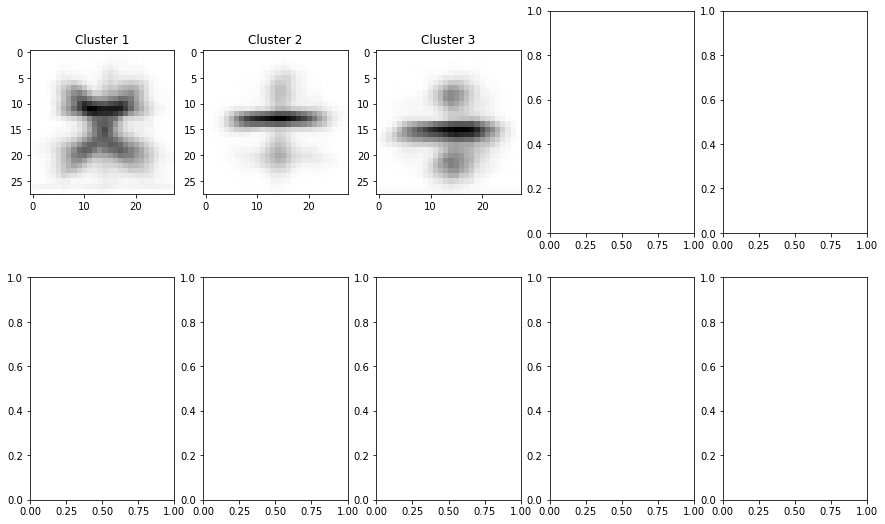

In [12]:
get_cluster_plot(Kmus_3)

In [31]:
def calcBer(x,t):
  matrix1 = t**x
  
  matrix2 = (1-t)**(1-x)
  matrix = matrix1*matrix2
  #print(np.prod(matrix))
  return np.prod(matrix, axis = 1)

def calcRespons(pi, theta, x, K):
    N,D = x.shape
    response = np.zeros((N,K))
    for k in range(K): 
        response[:,k] = pi[k] * calcBer(x, theta[k])
    response = np.divide(response, np.sum(response, axis = 1, keepdims=True))
    return response

def recalcParam(x, response, K):
    N,D = x.shape
    pi = np.zeros((K,1))
    theta = np.zeros((K,D))
    setNum = np.sum(response, axis=0)
    pi = setNum/N
    theta = np.divide(response.T @ x, np.sum(response, axis = 0, keepdims=True).T)
    return pi, theta

def train_EM_MOB(x , pi, theta, K): 
    '''
    :input arguments ---> data set, mixture probabilities, initial cluster locations and number of mixtures
    : Implement the EM algorithm for Mixture of Bernoulli random variables
    : HINT -> We strongly recommend to avoid two nested for loops. Try vectorising your code. 
    : A simple example of vectorisation is as follows :- 
    : Assume you have two vectors a and b. Suppose you want to find out the dot product of a and b. 
    : There are two ways -> 1. sum = 0 ; for i in range(len(a)): sum += a[i]*b[i] 
    : 2. sum = a.T @ b
    : The second method uses the matrix properties to get the same result as first. This is the main idea. 
    : Also it is a good idea to try out your own code with a small minibatch of data instead of the full data. 
    '''
    N, D = x.shape
    maxiters = 100
    response = np.zeros((N,K))
    for iter in range(maxiters):
        response = calcRespons(pi, theta, x, K)
        pi_new, theta_new = recalcParam(x, response, K)
        if np.sum(np.abs(theta.reshape((-1, 1)) - theta_new.reshape((-1, 1)))) < 1e-6:
            print(iter)
            break
        pi,theta = pi_new, theta_new
    return pi, theta

    


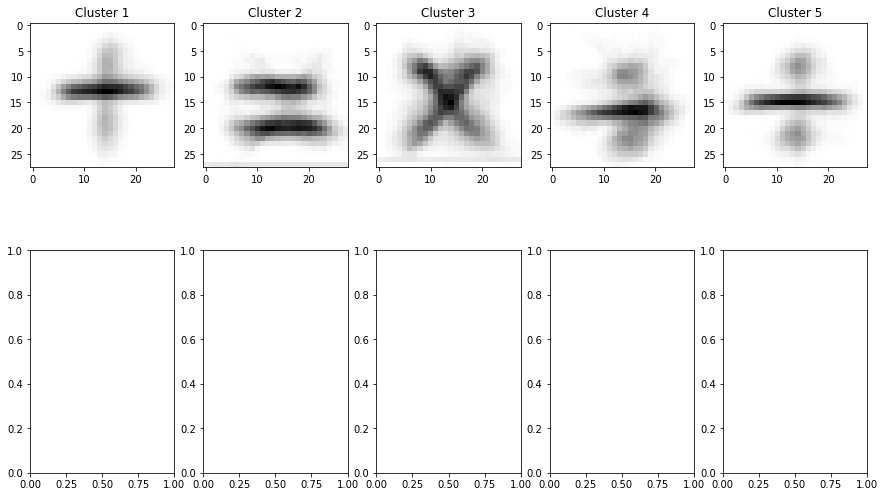

In [77]:
def get_cluster_plot(Kmus, rows = 2):
  '''
  : get a plot of what different clusters represent
  : takes as input the cluster location matrix
  '''
  fig,axs = plt.subplots(rows,5, figsize = (15,9))
  for i in range(len(Kmus)):
    cluster = Kmus[i].reshape(28,-1) * 255
    axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
    axs[i//5][i%5].set_title(f'Cluster {i + 1}')
get_cluster_plot(theta_new)

In [76]:
train = imgs
#Initialise the P(z = k) = $$\pi_k$$
pi3 = np.array([0.33,0.33,0.33])
pi5 = np.array([0.2,0.2,0.2,0.2,0.2])
#Initialise theta
# theta = Kmus_10
theta = np.random.uniform(low = 0.1, high = 0.5, size = (5,784)) # Using for my own because I dont want to run Kmeans again

#First try out with a small dataset
pi_new, theta_new = train_EM_MOB(train, pi5, theta, 5)
#After ensuring it works as expected, run on full dataset
#pi_new, theta_new = train_EM_MOB(train , pi, theta)
print(theta_new)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05245813 0.05245813 0.05245813]
 [0.         0.         0.         ... 0.00890858 0.00534515 0.00356343]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
print(theta_new.shape)

(5, 784)
